In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from pathlib import Path
import sys
import os


In [9]:
core_data_path = Path("/Users/riccardoconci/Local_documents/!CURRENT_RESEARCH/Personalising-Crutches/V2/data/raw/")
file_path_MIH27 = core_data_path / 'MIH27' / '2025-10-07' / 'surveys' / 'Surveys.csv'
file_path_MIH01 = core_data_path / 'MIH01' / '2025-10-15' / 'surveys' / 'surveys_202510151212.csv'
file_path_MIH15 = core_data_path / 'MIH15' / '2025-10-21' / 'surveys'/ 'trials_202510220822.csv'


MIH_27_surveys = pd.read_csv(file_path_MIH27)

MIH_01_surveys = pd.read_csv(file_path_MIH01)

MIH_15_surveys = pd.read_csv(file_path_MIH15)

# SURVEYS + IDs

In [10]:
participant_ID_details = {
    "MIH27": {
        "name": "MIH27",
        "age": 27,
        "gender": 0, # 0 = Male, 1 = Female
        "height": 170,
        "weight": 62,
        'forearm_length': 22,
        'activity_level':5, # 1 = Sedentary, 2 = Low, 3 = Moderate, 4 = High, 5 = Very High
        'previous_crutch_experience': 0, # 0 = No, 1 = Yes
    },
    "MIH01": {
        "name": "MIH01",
        "age": 25,
        "gender": 0, # 0 = Male, 1 = Female
        "height": 175,
        "weight": 70, 
        'forearm_length': 20,
        'activity_level':5,
        'previous_crutch_experience': 1,
    },
    "MIH15": {
        "name": "MIH15",
        "age": 21,
        "gender": 1, # 0 = Male, 1 = Female
        "height": 158,
        "weight": 58,
        'forearm_length': 23,
        'activity_level':5,
        'previous_crutch_experience': 0,
    }
}

participan_id_df = pd.DataFrame(participant_ID_details).T

participant_ID_to_MIH_ID = {3:'MIH27', 4:"MIH01", 5:"MIH15"}    
MIH_ID_to_participant_id = {v: k for k, v in participant_ID_to_MIH_ID.items()}
participan_id_df['participant_id'] = participan_id_df.index.map(MIH_ID_to_participant_id)
participan_id_df



,name,age,gender,height,weight,forearm_length,activity_level,previous_crutch_experience,participant_id
MIH27,MIH27,27,0,170,62,22,5,0,3
MIH01,MIH01,25,0,175,70,20,5,1,4
MIH15,MIH15,21,1,158,58,23,5,0,5


In [11]:
def compute_sus_score(df):
    sus_cols = ['sus_q1', 'sus_q2', 'sus_q3', 'sus_q4', 'sus_q5', 'sus_q6']
    positive_qs = ['sus_q1', 'sus_q2', 'sus_q4', 'sus_q5']
    negative_qs = ['sus_q3', 'sus_q6']
    
    df_copy = df.copy()
    # Apply scoring transformations
    df_copy[positive_qs] = df_copy[positive_qs].apply(lambda x: x - 1)
    df_copy[negative_qs] = df_copy[negative_qs].apply(lambda x: 5 - x)
    
    # Sum all scores and normalize to 0-100 scale
    # For 6-question SUS: (sum / 24) * 100
    # For standard 10-question SUS: sum * 2.5
    sus_score = (df_copy[sus_cols].sum(axis=1) / 24) * 100
    
    df_copy['sus_score'] = sus_score
    return df_copy

def compute_TLX_score(df, flip_performance=True):
    tlx_cols = ['tlx_mental_demand', 'tlx_physical_demand', 'tlx_performance', 'tlx_effort', 'tlx_frustration']
    if flip_performance:
        df['tlx_performance'] = 20 - df['tlx_performance']
    tlx_score = df[tlx_cols].mean(axis=1)
    df['tlx_score'] = tlx_score
    return df




In [12]:
participant_ID_cols = ['age', 'gender', 'height', 'weight', 'forearm_length', 'activity_level', 'previous_crutch_experience']
crutch_ID_cols = ['alpha', 'beta', 'gamma', 'timestamp']
linking_id =['participant_id']


CoT_cols = ['step_count', 'laps', 'metabolic_cost'] #'COT_score'
Instability_cols = ['step_variance'] # 'y_variance', 'step_frequency'



TLX_cols = ['tlx_mental_demand', 'tlx_physical_demand', 'tlx_performance', 'tlx_effort', 'tlx_frustration']
NRS_cols = ['nrs_score']
SUS_cols = ['sus_q1', 'sus_q2', 'sus_q3', 'sus_q4', 'sus_q5', 'sus_q6']



combined_surveys = pd.concat([MIH_01_surveys, MIH_15_surveys, MIH_27_surveys])
combined_survey_clean = combined_surveys.dropna(subset=['opencap_events'])

cols_to_keep = crutch_ID_cols + CoT_cols + Instability_cols + TLX_cols + NRS_cols + SUS_cols + linking_id
combined_survey_clean = combined_survey_clean[cols_to_keep]


combined_survey_clean = compute_TLX_score(combined_survey_clean)
combined_survey_clean = compute_sus_score(combined_survey_clean)


In [13]:
merged_df = combined_survey_clean.merge(
    participan_id_df[participant_ID_cols + ['participant_id']], 
    on='participant_id', 
    how='left'
)

# Display the result
merged_df.head()

,alpha,beta,gamma,timestamp,step_count,laps,metabolic_cost,step_variance,tlx_mental_demand,tlx_physical_demand,...,participant_id,tlx_score,sus_score,age,gender,height,weight,forearm_length,activity_level,previous_crutch_experience
0,95.0,95.0,0.0,2025-10-15 13:21:07,64.0,2.0,NaN,0.028320,6.0,10.0,...,4,10.6,58.333333,25,0,175,70,20,5,1
1,105.0,95.0,0.0,2025-10-15 13:29:32,65.0,2.0,NaN,0.049908,10.0,12.0,...,4,11.6,62.500000,25,0,175,70,20,5,1
2,105.0,125.0,0.0,2025-10-15 13:36:12,60.0,0.0,NaN,0.068931,12.0,13.0,...,4,13.0,54.166667,25,0,175,70,20,5,1
3,85.0,125.0,0.0,2025-10-15 13:46:06,69.0,2.0,NaN,0.017492,7.0,8.0,...,4,7.0,70.833333,25,0,175,70,20,5,1
4,85.0,95.0,0.0,2025-10-15 13:55:00,64.0,2.0,NaN,0.022959,10.0,9.0,...,4,11.6,45.833333,25,0,175,70,20,5,1


In [14]:
merged_df.columns

Index(['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps',
       'metabolic_cost', 'step_variance', 'tlx_mental_demand',
       'tlx_physical_demand', 'tlx_performance', 'tlx_effort',
       'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4',
       'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age',
       'gender', 'height', 'weight', 'forearm_length', 'activity_level',
       'previous_crutch_experience'],
      dtype='object')

In [15]:
MIH_27_full = merged_df.copy()
MIH_27_full = MIH_27_full[MIH_27_full['participant_id'] == 3]
MIH_01_full = merged_df.copy()
MIH_01_full = MIH_01_full[MIH_01_full['participant_id'] == 4]
MIH_15_full = merged_df.copy()
MIH_15_full = MIH_15_full[MIH_15_full['participant_id'] == 5]


In [16]:
MIH_27_full

,alpha,beta,gamma,timestamp,step_count,laps,metabolic_cost,step_variance,tlx_mental_demand,tlx_physical_demand,...,participant_id,tlx_score,sus_score,age,gender,height,weight,forearm_length,activity_level,previous_crutch_experience
26,95.0,95.0,0.0,2025-10-07 13:51:45,76.0,0.0,NaN,0.001828,10.0,7.0,...,3,7.2,75.000000,27,0,170,62,22,5,0
27,85.0,95.0,0.0,2025-10-07 13:58:26,69.0,0.0,NaN,0.006829,10.0,8.0,...,3,8.0,83.333333,27,0,170,62,22,5,0
28,85.0,125.0,0.0,2025-10-07 14:18:01,75.0,0.0,NaN,0.004956,12.0,9.0,...,3,9.8,45.833333,27,0,170,62,22,5,0
29,105.0,125.0,0.0,2025-10-07 14:24:07,72.0,0.0,NaN,0.012243,9.0,8.0,...,3,8.6,70.833333,27,0,170,62,22,5,0
30,105.0,95.0,0.0,2025-10-07 14:30:17,75.0,0.0,NaN,0.011958,7.0,9.0,...,3,7.4,79.166667,27,0,170,62,22,5,0
31,105.0,95.0,9.0,2025-10-07 14:44:39,79.0,0.0,NaN,0.004975,12.0,8.0,...,3,9.6,50.000000,27,0,170,62,22,5,0
32,105.0,125.0,9.0,2025-10-07 14:55:23,67.0,0.0,NaN,0.017198,8.0,8.0,...,3,8.2,62.500000,27,0,170,62,22,5,0
33,85.0,125.0,9.0,2025-10-07 15:06:19,69.0,0.0,NaN,0.018203,9.0,10.0,...,3,8.8,33.333333,27,0,170,62,22,5,0
34,85.0,95.0,9.0,2025-10-07 15:19:39,69.0,0.0,NaN,0.006257,5.0,10.0,...,3,7.2,70.833333,27,0,170,62,22,5,0
35,85.0,95.0,-9.0,2025-10-07 15:34:43,71.0,0.0,NaN,0.006558,5.0,10.0,...,3,7.2,58.333333,27,0,170,62,22,5,0


In [17]:
cols_to_exclude = ['timestamp', 'step_count', 'laps', 'step_variance', 'metabolic_cost', 'participant_id']

df_encoded = merged_df.copy()
df_encoded = df_encoded.drop(cols_to_exclude, axis=1)
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

df_compressed = df_encoded.copy()
cols_compressed = ['alpha', 'beta', 'gamma', 'tlx_score', 'nrs_score', 'sus_score']
df_compressed = df_compressed[cols_compressed]
df_encoded.head()


,alpha,beta,gamma,tlx_mental_demand,tlx_physical_demand,tlx_performance,tlx_effort,tlx_frustration,nrs_score,sus_q1,...,sus_q6,tlx_score,sus_score,age,gender,height,weight,forearm_length,activity_level,previous_crutch_experience
0,95.0,95.0,0.0,6.0,10.0,13.0,12.0,12.0,0.0,1.0,...,3.0,10.6,58.333333,25,0,175,70,20,5,1
1,105.0,95.0,0.0,10.0,12.0,12.0,11.0,13.0,0.0,2.0,...,4.0,11.6,62.500000,25,0,175,70,20,5,1
2,105.0,125.0,0.0,12.0,13.0,14.0,12.0,14.0,1.0,0.0,...,4.0,13.0,54.166667,25,0,175,70,20,5,1
3,85.0,125.0,0.0,7.0,8.0,6.0,8.0,6.0,0.0,2.0,...,4.0,7.0,70.833333,25,0,175,70,20,5,1
4,85.0,95.0,0.0,10.0,9.0,13.0,14.0,12.0,1.0,1.0,...,3.0,11.6,45.833333,25,0,175,70,20,5,1


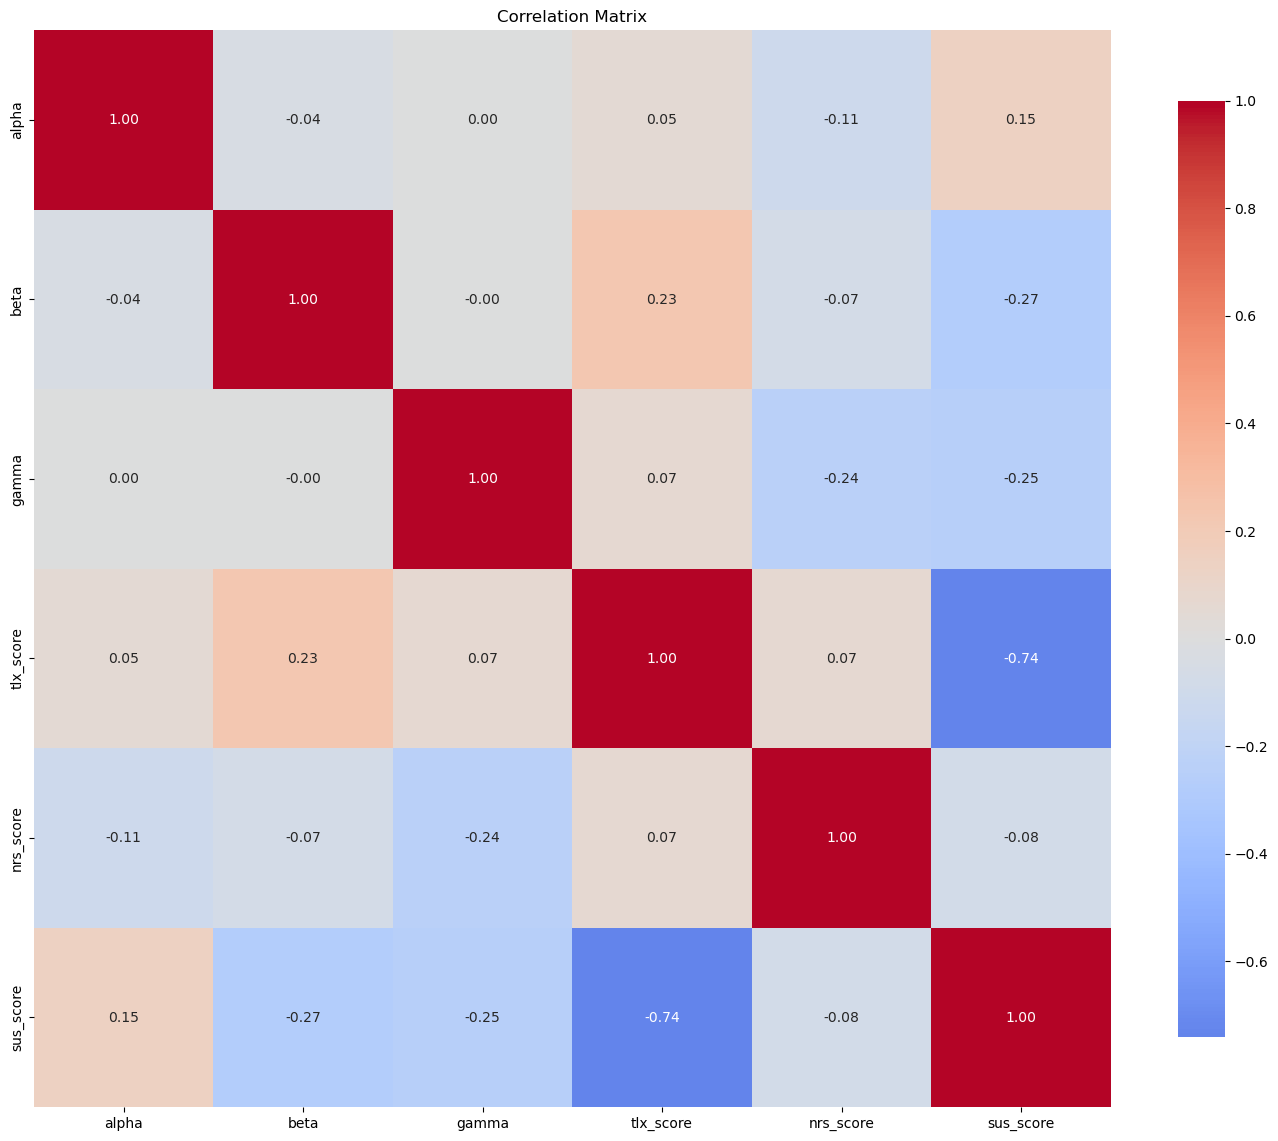

In [18]:
correlation_matrix_full = df_encoded.select_dtypes(include=[np.number]).corr()
correlation_matrix_compressed = df_compressed.select_dtypes(include=[np.number]).corr()
correlation_matrix_compressed
# Regular heatmap handles NaN better
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_compressed, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            square=True, 
            fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# METABOLICS


In [19]:
def calculate_cost_of_transport_vectorized(distance_m, time_s, power_per_kg_W_per_kg, include_gravity=False, g=9.81):
    """Vectorized version of cost_of_transport function"""
    v = distance_m / time_s  # m/s
    energy_per_kg = power_per_kg_W_per_kg * time_s  # J/kg
    energy_per_kg_per_m = energy_per_kg / distance_m  # J/(kg·m)
    
    if include_gravity:
        cot_dimless = power_per_kg_W_per_kg / (g * v)
        return energy_per_kg_per_m, cot_dimless
    else:
        return energy_per_kg_per_m


### MIH27

In [20]:
MIH27_metabolic_results_path = core_data_path / 'MIH27' / '2025-10-07' / 'metabolics' / 'metabolics_analysis' / 'interactive_metabolic_analysis_Metabolics_MH27_summary.csv'
MIH27_metabolic_results = pd.read_csv(MIH27_metabolic_results_path)
MIH27_metabolic_results


,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²
0,1,946.0,946.0 - 1347.0,25.940,987.0,17,41.0,7.491,9.390,0.044
1,2,1347.0,1347.0 - 2522.0,27.369,1447.0,47,100.0,8.568,10.907,0.291
2,3,2522.0,2522.0 - 2888.0,26.782,2585.0,39,63.0,7.344,8.800,0.077
3,4,2888.0,2888.0 - 3253.0,21.914,2999.0,74,111.0,8.678,10.926,0.170
4,5,3253.0,3253.0 - 4082.0,20.542,3334.0,48,81.0,7.963,11.270,0.291
5,6,4082.0,4082.0 - 4766.0,24.619,4182.0,57,100.0,5.832,23.348,0.160
6,7,4766.0,4766.0 - 5417.0,24.898,4855.0,59,89.0,7.959,10.579,0.121
7,8,5417.0,5417.0 - 6219.0,14.638,5485.0,40,68.0,6.419,8.229,0.151
8,9,6219.0,6219.0 - 7121.0,17.889,6294.0,48,75.0,6.774,9.695,0.230
9,10,7121.0,7121.0 - 7638.0,21.089,7206.0,56,85.0,7.235,9.071,0.090


In [21]:
MIH27_metabolic_results.columns

Index(['Marker', 'Marker Time (s)', 'Window (s)', 'Max Cost (W/kg)',
       'Max Time (s)', 'Cleaned Points', 'Cleaned Duration (s)',
       'Avg Cleaned (W/kg)', 'Extrapolated 5min (W/kg)', 'Fit R²'],
      dtype='object')

In [22]:
import pandas as pd
from io import StringIO

laps_MIH27 = """TRIAL NUMBER (alpha, beta, gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP
95,95,0, 2,31.7
85, 95, 0,2,24.8
85, 125, 0,2,14.6
105, 125, 0,2,17.2
105, 95, 0,2,27.0
105, 95, +9,2,20.8
105, 125, +9,2,14.3
85, 125, +9,2,2.6
85, 95, +9,2,15.9
85, 95, -9,2,21.4
85, 125, -9,2,23.1
105, 125, -9,2,22.1
105, 95, -9,2,19.7
95,95,0, 2,29.7
"""

laps_MIH27_df = pd.read_csv(StringIO(laps_MIH27))
full_lap = 36 #36m
laps_MIH27_df['total_distance'] = laps_MIH27_df['NUMBER OF FULL LAPS COMPLETED'] * full_lap + laps_MIH27_df['EXTRA DISTANCE AFTER FULL LAP']

In [23]:
laps_MIH27_df.columns

Index(['TRIAL NUMBER (alpha', ' beta', ' gamma)',
       'NUMBER OF FULL LAPS COMPLETED', 'EXTRA DISTANCE AFTER FULL LAP',
       'total_distance'],
      dtype='object')

In [24]:
combined_metabolics_MIH27 = pd.concat([MIH27_metabolic_results, laps_MIH27_df], axis=1)
combined_metabolics_MIH27

,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance
0,1,946.0,946.0 - 1347.0,25.940,987.0,17,41.0,7.491,9.390,0.044,95,95,0,2,31.7,103.7
1,2,1347.0,1347.0 - 2522.0,27.369,1447.0,47,100.0,8.568,10.907,0.291,85,95,0,2,24.8,96.8
2,3,2522.0,2522.0 - 2888.0,26.782,2585.0,39,63.0,7.344,8.800,0.077,85,125,0,2,14.6,86.6
3,4,2888.0,2888.0 - 3253.0,21.914,2999.0,74,111.0,8.678,10.926,0.170,105,125,0,2,17.2,89.2
4,5,3253.0,3253.0 - 4082.0,20.542,3334.0,48,81.0,7.963,11.270,0.291,105,95,0,2,27.0,99.0
5,6,4082.0,4082.0 - 4766.0,24.619,4182.0,57,100.0,5.832,23.348,0.160,105,95,9,2,20.8,92.8
6,7,4766.0,4766.0 - 5417.0,24.898,4855.0,59,89.0,7.959,10.579,0.121,105,125,9,2,14.3,86.3
7,8,5417.0,5417.0 - 6219.0,14.638,5485.0,40,68.0,6.419,8.229,0.151,85,125,9,2,2.6,74.6
8,9,6219.0,6219.0 - 7121.0,17.889,6294.0,48,75.0,6.774,9.695,0.230,85,95,9,2,15.9,87.9
9,10,7121.0,7121.0 - 7638.0,21.089,7206.0,56,85.0,7.235,9.071,0.090,85,95,-9,2,21.4,93.4


In [25]:
combined_metabolics_MIH27['cost_of_transport'] = calculate_cost_of_transport_vectorized(
    distance_m=combined_metabolics_MIH27['total_distance'],
    time_s=120,
    power_per_kg_W_per_kg=combined_metabolics_MIH27['Extrapolated 5min (W/kg)'],
    include_gravity=False
)

In [26]:

combined_metabolics_MIH27['cost_of_transport'] = combined_metabolics_MIH27['cost_of_transport'].clip(upper=17)

In [68]:
combined_metabolics_MIH27

,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance,cost_of_transport
0,1,946.0,946.0 - 1347.0,25.940,987.0,17,41.0,7.491,9.390,0.044,95,95,0,2,31.7,103.7,10.865959
1,2,1347.0,1347.0 - 2522.0,27.369,1447.0,47,100.0,8.568,10.907,0.291,85,95,0,2,24.8,96.8,13.521074
2,3,2522.0,2522.0 - 2888.0,26.782,2585.0,39,63.0,7.344,8.800,0.077,85,125,0,2,14.6,86.6,12.193995
3,4,2888.0,2888.0 - 3253.0,21.914,2999.0,74,111.0,8.678,10.926,0.170,105,125,0,2,17.2,89.2,14.698655
4,5,3253.0,3253.0 - 4082.0,20.542,3334.0,48,81.0,7.963,11.270,0.291,105,95,0,2,27.0,99.0,13.660606
5,6,4082.0,4082.0 - 4766.0,24.619,4182.0,57,100.0,5.832,23.348,0.160,105,95,9,2,20.8,92.8,17.000000
6,7,4766.0,4766.0 - 5417.0,24.898,4855.0,59,89.0,7.959,10.579,0.121,105,125,9,2,14.3,86.3,14.710081
7,8,5417.0,5417.0 - 6219.0,14.638,5485.0,40,68.0,6.419,8.229,0.151,85,125,9,2,2.6,74.6,13.236997
8,9,6219.0,6219.0 - 7121.0,17.889,6294.0,48,75.0,6.774,9.695,0.230,85,95,9,2,15.9,87.9,13.235495
9,10,7121.0,7121.0 - 7638.0,21.089,7206.0,56,85.0,7.235,9.071,0.090,85,95,-9,2,21.4,93.4,11.654390


### MIH01

In [27]:
MIH01_metabolic_results_path = core_data_path / 'MIH01' / '2025-10-15' / 'metabolics' / 'metabolics_analysis' / 'interactive_metabolic_analysis_TEST_NO_1108_summary.csv'
MIH01_metabolic_results = pd.read_csv(MIH01_metabolic_results_path)
MIH01_metabolic_results


,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²
0,1,940.0,940.0 - 1448.0,10.836,980.0,23,40.0,3.662,15.000,0.188
1,2,1448.0,1448.0 - 1839.0,11.419,1568.0,60,120.0,6.993,10.165,0.832
2,3,1839.0,1839.0 - 2438.0,20.015,1954.0,65,115.0,6.910,9.707,0.339
3,4,2438.0,2438.0 - 2973.0,13.859,2544.0,59,106.0,7.211,12.314,0.630
4,5,2973.0,2973.0 - 3699.0,12.900,3093.0,64,120.0,8.001,11.477,0.801
5,6,3699.0,3699.0 - 4120.0,13.608,3789.0,56,90.0,7.032,12.852,0.553
6,7,4120.0,4120.0 - 4610.0,17.123,4222.0,63,102.0,7.947,11.568,0.515
7,8,4610.0,4610.0 - 5049.0,17.394,4651.0,23,41.0,5.491,9.555,0.364
8,9,5049.0,5049.0 - 5779.0,13.964,5166.0,66,117.0,8.901,13.567,0.819
9,10,5779.0,5779.0 - 6086.0,14.190,5807.0,15,28.0,3.664,15.000,0.294


In [28]:
laps_MIH01 = """TRIAL NUMBER (alpha, beta, gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP
95, 95, 0, 2,13
105, 95, 0,2,13
105, 125,0,2,3.9
85, 125,0,2,24.0
85, 95, 0,2,2.9
85,95, -9,2,20.7
85, 125, -9,2,16.9
105, 125, -9,2,15.2
85, 95, -9,2,12.1
105, 95, +9,2,15.0
105, 125, +9,2,9.5
85,125, +9,2,19.2
85,95, +9,2,13.6
95,95,0, 2,33
"""

laps_MIH01_df = pd.read_csv(StringIO(laps_MIH01))
full_lap = 36 #36m
laps_MIH01_df['total_distance'] = laps_MIH01_df['NUMBER OF FULL LAPS COMPLETED'] * full_lap + laps_MIH01_df['EXTRA DISTANCE AFTER FULL LAP']
laps_MIH01_df

,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance
0,95,95,0,2,13.0,85.0
1,105,95,0,2,13.0,85.0
2,105,125,0,2,3.9,75.9
3,85,125,0,2,24.0,96.0
4,85,95,0,2,2.9,74.9
5,85,95,-9,2,20.7,92.7
6,85,125,-9,2,16.9,88.9
7,105,125,-9,2,15.2,87.2
8,85,95,-9,2,12.1,84.1
9,105,95,9,2,15.0,87.0


In [29]:
combined_metabolics_MIH01 = pd.concat([MIH01_metabolic_results, laps_MIH01_df], axis=1)
combined_metabolics_MIH01
combined_metabolics_MIH01['cost_of_transport'] = calculate_cost_of_transport_vectorized(
    distance_m=combined_metabolics_MIH01['total_distance'],
    time_s=120,
    power_per_kg_W_per_kg=combined_metabolics_MIH01['Extrapolated 5min (W/kg)'],
    include_gravity=False
)

In [30]:
combined_metabolics_MIH01

,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance,cost_of_transport
0,1,940.0,940.0 - 1448.0,10.836,980.0,23,40.0,3.662,15.000,0.188,95,95,0,2,13.0,85.0,21.176471
1,2,1448.0,1448.0 - 1839.0,11.419,1568.0,60,120.0,6.993,10.165,0.832,105,95,0,2,13.0,85.0,14.350588
2,3,1839.0,1839.0 - 2438.0,20.015,1954.0,65,115.0,6.910,9.707,0.339,105,125,0,2,3.9,75.9,15.347036
3,4,2438.0,2438.0 - 2973.0,13.859,2544.0,59,106.0,7.211,12.314,0.630,85,125,0,2,24.0,96.0,15.392500
4,5,2973.0,2973.0 - 3699.0,12.900,3093.0,64,120.0,8.001,11.477,0.801,85,95,0,2,2.9,74.9,18.387717
5,6,3699.0,3699.0 - 4120.0,13.608,3789.0,56,90.0,7.032,12.852,0.553,85,95,-9,2,20.7,92.7,16.636893
6,7,4120.0,4120.0 - 4610.0,17.123,4222.0,63,102.0,7.947,11.568,0.515,85,125,-9,2,16.9,88.9,15.614848
7,8,4610.0,4610.0 - 5049.0,17.394,4651.0,23,41.0,5.491,9.555,0.364,105,125,-9,2,15.2,87.2,13.149083
8,9,5049.0,5049.0 - 5779.0,13.964,5166.0,66,117.0,8.901,13.567,0.819,85,95,-9,2,12.1,84.1,19.358383
9,10,5779.0,5779.0 - 6086.0,14.190,5807.0,15,28.0,3.664,15.000,0.294,105,95,9,2,15.0,87.0,20.689655


### MIH15

In [31]:
MIH15_metabolic_results_path = core_data_path / 'MIH15' / '2025-10-21' / 'Metabolics' / 'metabolics_analysis' / 'interactive_metabolic_analysis_TEST_NO_1159_summary.csv'
MIH15_metabolic_results = pd.read_csv(MIH15_metabolic_results_path)
MIH15_metabolic_results

,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²
0,1,829.0,829.0 - 1767.0,14.045,970.0,86,141.0,8.513,11.398,0.770
1,2,1767.0,1767.0 - 2137.0,12.403,1896.0,71,129.0,6.302,22.105,0.799
2,3,2137.0,2137.0 - 2450.0,16.476,2284.0,97,147.0,9.028,12.452,0.816
3,4,2450.0,2450.0 - 2708.0,13.122,2574.0,84,124.0,8.608,12.460,0.924
4,5,2708.0,2708.0 - 3073.0,14.588,2850.0,99,142.0,9.345,12.367,0.824
5,6,3073.0,3073.0 - 3750.0,13.916,3217.0,87,144.0,8.751,12.609,0.840
6,7,3750.0,3750.0 - 4210.0,14.025,3892.0,84,142.0,8.509,11.947,0.843
7,8,4654.0,4654.0 - 4921.0,17.202,4787.0,89,133.0,9.267,12.150,0.801
8,9,4921.0,4921.0 - 5979.0,13.380,5049.0,81,128.0,8.041,16.424,0.885
9,10,5979.0,5979.0 - 6343.0,13.998,6124.0,103,145.0,8.858,14.431,0.834


In [32]:
steps_MIH15 = """TRIAL NUMBER (alpha, beta, gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP
95, 95, 0, 2,35
105, 95, -9,2,30.9
105, 125, -9,3,5.7
85, 125, -9,3,16.3
85, 95, -9,3,2.4
85, 95, +9,2,32.6
85, 125, +9,3,19.2
105, 125, +9,3,4.4
105, 95, +9,3,7
105, 95, 0,3,11.7
105, 125, 0,3,8.1
85, 125, 0,3,6.6
85, 95, 0,3,0
95,95,0, 2,33
"""

steps_MIH15_df = pd.read_csv(StringIO(steps_MIH15))
full_lap = 36 #36m
steps_MIH15_df['total_distance'] = steps_MIH15_df['NUMBER OF FULL LAPS COMPLETED'] * full_lap + steps_MIH15_df['EXTRA DISTANCE AFTER FULL LAP']
steps_MIH15_df

,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance
0,95,95,0,2,35.0,107.0
1,105,95,-9,2,30.9,102.9
2,105,125,-9,3,5.7,113.7
3,85,125,-9,3,16.3,124.3
4,85,95,-9,3,2.4,110.4
5,85,95,9,2,32.6,104.6
6,85,125,9,3,19.2,127.2
7,105,125,9,3,4.4,112.4
8,105,95,9,3,7.0,115.0
9,105,95,0,3,11.7,119.7


In [33]:
combined_metabolics_MIH15 = pd.concat([MIH15_metabolic_results, steps_MIH15_df], axis=1)
combined_metabolics_MIH15
combined_metabolics_MIH15['cost_of_transport'] = calculate_cost_of_transport_vectorized(
    distance_m=combined_metabolics_MIH15['total_distance'],
    time_s=120,
    power_per_kg_W_per_kg=combined_metabolics_MIH15['Extrapolated 5min (W/kg)'],
    include_gravity=False
)

In [34]:
combined_metabolics_MIH15

,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance,cost_of_transport
0,1,829.0,829.0 - 1767.0,14.045,970.0,86,141.0,8.513,11.398,0.770,95,95,0,2,35.0,107.0,12.782804
1,2,1767.0,1767.0 - 2137.0,12.403,1896.0,71,129.0,6.302,22.105,0.799,105,95,-9,2,30.9,102.9,25.778426
2,3,2137.0,2137.0 - 2450.0,16.476,2284.0,97,147.0,9.028,12.452,0.816,105,125,-9,3,5.7,113.7,13.141953
3,4,2450.0,2450.0 - 2708.0,13.122,2574.0,84,124.0,8.608,12.460,0.924,85,125,-9,3,16.3,124.3,12.028962
4,5,2708.0,2708.0 - 3073.0,14.588,2850.0,99,142.0,9.345,12.367,0.824,85,95,-9,3,2.4,110.4,13.442391
5,6,3073.0,3073.0 - 3750.0,13.916,3217.0,87,144.0,8.751,12.609,0.840,85,95,9,2,32.6,104.6,14.465392
6,7,3750.0,3750.0 - 4210.0,14.025,3892.0,84,142.0,8.509,11.947,0.843,85,125,9,3,19.2,127.2,11.270755
7,8,4654.0,4654.0 - 4921.0,17.202,4787.0,89,133.0,9.267,12.150,0.801,105,125,9,3,4.4,112.4,12.971530
8,9,4921.0,4921.0 - 5979.0,13.380,5049.0,81,128.0,8.041,16.424,0.885,105,95,9,3,7.0,115.0,17.138087
9,10,5979.0,5979.0 - 6343.0,13.998,6124.0,103,145.0,8.858,14.431,0.834,105,95,0,3,11.7,119.7,14.467168


# IMU


In [35]:
import pandas as pd
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up paths
db_path = Path('/Users/riccardoconci/Local_documents/!CURRENT_RESEARCH/Personalising-Crutches/V2/experiments.db')

print(f"Database path: {db_path}")
print(f"Database exists: {db_path.exists()}")

# Connect to database and extract steps data
conn = sqlite3.connect(str(db_path))

# Query for steps data
query = """
SELECT 
    id as trial_id,
    participant_id,
    steps,
    step_count,
    step_variance,
    timestamp,
    alpha,
    beta,
    gamma
FROM trials 
WHERE steps IS NOT NULL
ORDER BY trial_id
"""

df_steps = pd.read_sql_query(query, conn)
conn.close()

print(f"Found {len(df_steps)} trials with steps data")
print(f"Columns: {df_steps.columns.tolist()}")
df_steps.head()


Database path: /Users/riccardoconci/Local_documents/!CURRENT_RESEARCH/Personalising-Crutches/V2/experiments.db
Database exists: True
Found 71 trials with steps data
Columns: ['trial_id', 'participant_id', 'steps', 'step_count', 'step_variance', 'timestamp', 'alpha', 'beta', 'gamma']


,trial_id,participant_id,steps,step_count,step_variance,timestamp,alpha,beta,gamma
0,1,2,"[0.6200000000000006, 1.120000000000001, 1.7400...",NaN,NaN,2025-10-03 14:48:20,85.0,95.0,9.0
1,2,2,"[0.889999999999981, 1.6999999999999638, 2.4899...",78.0,0.018245,2025-10-03 17:53:41,95.0,95.0,0.0
2,3,2,"[0.889999999999981, 1.6999999999999638, 2.4899...",78.0,0.018245,2025-10-03 17:57:24,85.0,95.0,-9.0
3,4,2,"[4.044999999999914, 4.459999999999905, 6.33499...",16.0,0.156962,2025-10-07 12:32:40,105.0,95.0,-9.0
4,5,3,"[2.4249999999999483, 3.1249999999999334, 3.904...",76.0,0.001828,2025-10-07 13:51:45,95.0,95.0,0.0


In [36]:
df_steps = df_steps[df_steps['participant_id'].isin([3, 4, 5])]
df_steps.sort_values(by='timestamp', inplace=True)
df_steps

,trial_id,participant_id,steps,step_count,step_variance,timestamp,alpha,beta,gamma
4,5,3,"[2.4249999999999483, 3.1249999999999334, 3.904...",76.0,0.001828,2025-10-07 13:51:45,95.0,95.0,0.0
5,6,3,"[3.854999999999918, 4.739999999999899, 5.48999...",69.0,0.006829,2025-10-07 13:58:26,85.0,95.0,0.0
6,7,3,"[2.7899999999999405, 3.4949999999999255, 4.209...",75.0,0.004956,2025-10-07 14:18:01,85.0,125.0,0.0
7,8,3,"[2.399999999999949, 3.189999999999932, 3.95499...",72.0,0.012243,2025-10-07 14:24:07,105.0,125.0,0.0
8,9,3,"[1.9149999999999592, 2.6549999999999434, 3.369...",75.0,0.011958,2025-10-07 14:30:17,105.0,95.0,0.0
9,10,3,"[2.2199999999999527, 3.1249999999999334, 3.854...",79.0,0.004975,2025-10-07 14:44:39,105.0,95.0,9.0
10,11,3,"[3.194999999999932, 4.019999999999914, 4.76999...",67.0,0.017198,2025-10-07 14:55:23,105.0,125.0,9.0
11,12,3,"[2.3299999999999503, 3.1649999999999325, 4.059...",69.0,0.018203,2025-10-07 15:06:19,85.0,125.0,9.0
12,13,3,"[5.684999999999879, 6.464999999999862, 7.25499...",69.0,0.006257,2025-10-07 15:19:39,85.0,95.0,9.0
13,14,3,"[2.3299999999999503, 3.0649999999999347, 3.809...",71.0,0.006558,2025-10-07 15:34:43,85.0,95.0,-9.0


In [37]:
df_steps.columns

Index(['trial_id', 'participant_id', 'steps', 'step_count', 'step_variance',
       'timestamp', 'alpha', 'beta', 'gamma'],
      dtype='object')

# Plotly plots

In [38]:
from plot_compressed import create_3d_score_plot

In [39]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import linregress

def plot_order_vs_score(
    df: pd.DataFrame,
    score_column: str,
    title: str = None,
    use_existing_testing_order: bool = True
) -> go.Figure:
    """
    Scatter the score vs the test order (1..N) and overlay a linear regression line.

    Args:
        df: DataFrame with at least `score_column` and optionally `testing_order`.
        score_column: Column name of the score to plot.
        title: Plot title (optional).
        use_existing_testing_order: If True and 'testing_order' exists, use it;
                                    otherwise use the row order (1..N).

    Returns:
        Plotly Figure
    """
    # Choose x = testing order
    if use_existing_testing_order and 'testing_order' in df.columns:
        x = df['testing_order'].to_numpy()
    else:
        # Preserve current row order
        x = np.arange(1, len(df) + 1)

    # y = the score column
    if score_column not in df.columns:
        raise ValueError(f"Column '{score_column}' not found in DataFrame.")
    y = df[score_column].to_numpy()

    # Keep only finite pairs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    fig = go.Figure()

    if x.size == 0:
        # Nothing to show
        fig.update_layout(title=title or f"{score_column} vs Order")
        return fig

    # Scatter points
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=score_column.replace('_', ' ').title(),
        marker=dict(size=9, opacity=0.9, line=dict(width=1, color='black')),
        hovertemplate="Order %{x}<br>Score %{y:.3f}<extra></extra>"
    ))

    # Fit simple linear regression
    slope, intercept, r, p, _ = linregress(x, y)
    x_line = np.array([x.min(), x.max()])
    y_line = slope * x_line + intercept

    fig.add_trace(go.Scatter(
        x=x_line,
        y=y_line,
        mode='lines',
        name=f"Fit: y = {slope:.3f}x + {intercept:.3f} (R²={r**2:.3f}, p={p:.3g})"
    ))

    # Layout
    fig.update_layout(
        title=title or f"{score_column} vs Testing Order",
        xaxis_title="Testing Order (1..N)",
        yaxis_title=score_column.replace('_', ' ').title(),
        template="plotly_white",
        width=800,
        height=500,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
    )

    return fig

## MIH27

In [40]:
combined_metabolics_MIH27.columns

Index(['Marker', 'Marker Time (s)', 'Window (s)', 'Max Cost (W/kg)',
       'Max Time (s)', 'Cleaned Points', 'Cleaned Duration (s)',
       'Avg Cleaned (W/kg)', 'Extrapolated 5min (W/kg)', 'Fit R²',
       'TRIAL NUMBER (alpha', ' beta', ' gamma)',
       'NUMBER OF FULL LAPS COMPLETED', 'EXTRA DISTANCE AFTER FULL LAP',
       'total_distance', 'cost_of_transport'],
      dtype='object')

In [41]:
combined_metabolics_clean = combined_metabolics_MIH27.copy()

combined_metabolics_clean = combined_metabolics_clean.rename(columns={
    'TRIAL NUMBER (alpha': 'alpha',
    ' beta': 'beta', 
    ' gamma)': 'gamma'
})
metabolic_cols_to_merge = ['alpha', 'beta', 'gamma', 'Extrapolated 5min (W/kg)', 'total_distance', 'cost_of_transport','Fit R²']
metabolic_data_for_merge = combined_metabolics_clean[metabolic_cols_to_merge]


In [42]:
MIH_27_full_merged = MIH_27_full.merge(
    metabolic_data_for_merge,
    on=['alpha', 'beta', 'gamma'],
    how='left'
)

In [43]:
MIH_27_full_merged.columns

Index(['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps',
       'metabolic_cost', 'step_variance', 'tlx_mental_demand',
       'tlx_physical_demand', 'tlx_performance', 'tlx_effort',
       'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4',
       'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age',
       'gender', 'height', 'weight', 'forearm_length', 'activity_level',
       'previous_crutch_experience', 'Extrapolated 5min (W/kg)',
       'total_distance', 'cost_of_transport', 'Fit R²'],
      dtype='object')

In [44]:
MIH_27_full_merged.columns

Index(['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps',
       'metabolic_cost', 'step_variance', 'tlx_mental_demand',
       'tlx_physical_demand', 'tlx_performance', 'tlx_effort',
       'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4',
       'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age',
       'gender', 'height', 'weight', 'forearm_length', 'activity_level',
       'previous_crutch_experience', 'Extrapolated 5min (W/kg)',
       'total_distance', 'cost_of_transport', 'Fit R²'],
      dtype='object')

In [45]:
from plot_compressed import comprehensive_gp_analysis, create_gp_summary_plot
target_cols = ['cost_of_transport', 'step_variance', 'tlx_score', 'sus_score', 'nrs_score']

# Run the GP analysis
results_df, summary = comprehensive_gp_analysis(
    df=MIH_27_full_merged,
    target_columns=target_cols,
    lengthscales=[10, 15, 30, 50,75, 100],  # Different "wavelengths"
    output_dir="gp_analysis_MIH27"
)

# Create the wavelength summary plot
summary_fig = create_gp_summary_plot(
    results_df, 
    title="Predicted Optimal Geometries (Color by Metric, Shade by Lengthscale)"
)

# Show the plot
summary_fig.show()

COMPREHENSIVE GP ANALYSIS

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 10 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75.  140.   10.5]
  Predicted Min Value: 2.3511
[INFO] Saved plot to: gp_analysis_MIH27/cost_of_transport_lengthscale_10.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 15 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75.  140.   10.5]
  Predicted Min Value: 4.6974
[INFO] Saved plot to: gp_analysis_MIH27/cost_of_transport_lengthscale_15.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 30 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75. 140.   5.]
  Predicted Min Value: 9.0324
[INFO] Saved plot to: gp_analysis_MIH27/cost_of_transport_lengthscale_30.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 50 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 97. 100. -10.]
  Predicted Min Value: 9.8026
[INFO] Saved plot to: gp_analysis_MIH27/cost_of_transport_lengthscale_50.html

--- Processing 'COST_OF_TRANSPORT' with

In [46]:
tlx_fig = create_3d_score_plot(MIH_27_full, 'tlx_score', 'TLX Score (Lower is Better)', reverse_scale=True)
sus_fig = create_3d_score_plot(MIH_27_full, 'sus_score', 'SUS Score (Higher is Better)', reverse_scale=False)
nrs_fig = create_3d_score_plot(MIH_27_full, 'nrs_score', 'NRS Score (Lower is Better)', reverse_scale=True)
instability_fig = create_3d_score_plot(MIH_27_full, 'step_variance', 'Step Variance (Lower is Better)', reverse_scale=True)
cost_of_transport_fig = create_3d_score_plot(MIH_27_full_merged, 'cost_of_transport', 'Cost of Transport (Lower is Better)', reverse_scale=True)
# Show plots
tlx_fig.show()
sus_fig.show()
nrs_fig.show()
cost_of_transport_fig.show()
instability_fig.show()



Handled duplicates: 14 original rows -> 13 unique configurations
Handled duplicates: 14 original rows -> 13 unique configurations
Handled duplicates: 14 original rows -> 13 unique configurations
Handled duplicates: 14 original rows -> 13 unique configurations
Handled duplicates: 16 original rows -> 13 unique configurations


In [47]:
cost_of_transport_temporal_fig = plot_order_vs_score(MIH_27_full_merged, 'cost_of_transport', title="Cost of Transport vs Order")
cost_of_transport_temporal_fig.show()

tlx_temproal_fig = plot_order_vs_score(MIH_27_full, 'tlx_score', title="TLX vs Order")
tlx_temproal_fig.show()
fig2 = plot_order_vs_score(MIH_27_full, 'sus_score', use_existing_testing_order=True)
fig2.show()
fig_instability = plot_order_vs_score(MIH_27_full, 'step_variance', use_existing_testing_order=True)
fig_instability.show()


fig_nrs = plot_order_vs_score(MIH_27_full, 'nrs_score', use_existing_testing_order=True)
fig_nrs.show()

## MIH01

In [48]:
MIH_01_full.columns

Index(['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps',
       'metabolic_cost', 'step_variance', 'tlx_mental_demand',
       'tlx_physical_demand', 'tlx_performance', 'tlx_effort',
       'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4',
       'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age',
       'gender', 'height', 'weight', 'forearm_length', 'activity_level',
       'previous_crutch_experience'],
      dtype='object')

In [49]:
combined_metabolics_MIH01

,Marker,Marker Time (s),Window (s),Max Cost (W/kg),Max Time (s),Cleaned Points,Cleaned Duration (s),Avg Cleaned (W/kg),Extrapolated 5min (W/kg),Fit R²,TRIAL NUMBER (alpha,beta,gamma),NUMBER OF FULL LAPS COMPLETED,EXTRA DISTANCE AFTER FULL LAP,total_distance,cost_of_transport
0,1,940.0,940.0 - 1448.0,10.836,980.0,23,40.0,3.662,15.000,0.188,95,95,0,2,13.0,85.0,21.176471
1,2,1448.0,1448.0 - 1839.0,11.419,1568.0,60,120.0,6.993,10.165,0.832,105,95,0,2,13.0,85.0,14.350588
2,3,1839.0,1839.0 - 2438.0,20.015,1954.0,65,115.0,6.910,9.707,0.339,105,125,0,2,3.9,75.9,15.347036
3,4,2438.0,2438.0 - 2973.0,13.859,2544.0,59,106.0,7.211,12.314,0.630,85,125,0,2,24.0,96.0,15.392500
4,5,2973.0,2973.0 - 3699.0,12.900,3093.0,64,120.0,8.001,11.477,0.801,85,95,0,2,2.9,74.9,18.387717
5,6,3699.0,3699.0 - 4120.0,13.608,3789.0,56,90.0,7.032,12.852,0.553,85,95,-9,2,20.7,92.7,16.636893
6,7,4120.0,4120.0 - 4610.0,17.123,4222.0,63,102.0,7.947,11.568,0.515,85,125,-9,2,16.9,88.9,15.614848
7,8,4610.0,4610.0 - 5049.0,17.394,4651.0,23,41.0,5.491,9.555,0.364,105,125,-9,2,15.2,87.2,13.149083
8,9,5049.0,5049.0 - 5779.0,13.964,5166.0,66,117.0,8.901,13.567,0.819,85,95,-9,2,12.1,84.1,19.358383
9,10,5779.0,5779.0 - 6086.0,14.190,5807.0,15,28.0,3.664,15.000,0.294,105,95,9,2,15.0,87.0,20.689655


In [50]:
combined_metabolics_clean_01 = combined_metabolics_MIH01.copy()

combined_metabolics_clean_01 = combined_metabolics_clean_01.rename(columns={
    'TRIAL NUMBER (alpha': 'alpha',
    ' beta': 'beta', 
    ' gamma)': 'gamma'
})
metabolic_cols_to_merge = ['alpha', 'beta', 'gamma', 'Extrapolated 5min (W/kg)', 'total_distance', 'cost_of_transport','Fit R²']
metabolic_data_for_merge_MIH01 = combined_metabolics_clean_01[metabolic_cols_to_merge]


In [51]:
metabolic_data_for_merge_MIH01.head()

,alpha,beta,gamma,Extrapolated 5min (W/kg),total_distance,cost_of_transport,Fit R²
0,95,95,0,15.000,85.0,21.176471,0.188
1,105,95,0,10.165,85.0,14.350588,0.832
2,105,125,0,9.707,75.9,15.347036,0.339
3,85,125,0,12.314,96.0,15.392500,0.630
4,85,95,0,11.477,74.9,18.387717,0.801


In [52]:
#MIH_01_full.drop(columns=['cost_of_transport', 'total_distance','Extrapolated 5min (W/kg)'], inplace=True)

In [53]:
MIH_01_full_merged = MIH_01_full.merge(
    metabolic_data_for_merge_MIH01,
    on=['alpha', 'beta', 'gamma'],
    how='left'
)

In [54]:
MIH_01_full_merged.head()

,alpha,beta,gamma,timestamp,step_count,laps,metabolic_cost,step_variance,tlx_mental_demand,tlx_physical_demand,...,gender,height,weight,forearm_length,activity_level,previous_crutch_experience,Extrapolated 5min (W/kg),total_distance,cost_of_transport,Fit R²
0,95.0,95.0,0.0,2025-10-15 13:21:07,64.0,2.0,NaN,0.028320,6.0,10.0,...,0,175,70,20,5,1,15.000,85.0,21.176471,0.188
1,95.0,95.0,0.0,2025-10-15 13:21:07,64.0,2.0,NaN,0.028320,6.0,10.0,...,0,175,70,20,5,1,15.512,105.0,17.728000,0.674
2,105.0,95.0,0.0,2025-10-15 13:29:32,65.0,2.0,NaN,0.049908,10.0,12.0,...,0,175,70,20,5,1,10.165,85.0,14.350588,0.832
3,105.0,125.0,0.0,2025-10-15 13:36:12,60.0,0.0,NaN,0.068931,12.0,13.0,...,0,175,70,20,5,1,9.707,75.9,15.347036,0.339
4,85.0,125.0,0.0,2025-10-15 13:46:06,69.0,2.0,NaN,0.017492,7.0,8.0,...,0,175,70,20,5,1,12.314,96.0,15.392500,0.630


In [55]:
from plot_compressed import comprehensive_gp_analysis, create_gp_summary_plot
target_cols = ['step_variance', 'tlx_score', 'sus_score', 'nrs_score', 'cost_of_transport']

# Run the GP analysis
results_df, summary = comprehensive_gp_analysis(
    df=MIH_01_full_merged,
    target_columns=target_cols,
    lengthscales=[10, 15, 30, 50,75, 100],  # Different "wavelengths"
    output_dir="gp_analysis_MIH01"
)

# Create the wavelength summary plot
summary_fig = create_gp_summary_plot(
    results_df, 
    title="Predicted Optimal Geometries (Color by Metric, Shade by Lengthscale)"
)

# Show the plot
summary_fig.show()

COMPREHENSIVE GP ANALYSIS

--- Processing 'STEP_VARIANCE' with Lengthscale: 10 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 97.  100.    6.5]
  Predicted Min Value: -0.0306
[INFO] Saved plot to: gp_analysis_MIH01/step_variance_lengthscale_10.html

--- Processing 'STEP_VARIANCE' with Lengthscale: 15 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 97. 100.   8.]
  Predicted Min Value: -0.0686
[INFO] Saved plot to: gp_analysis_MIH01/step_variance_lengthscale_15.html

--- Processing 'STEP_VARIANCE' with Lengthscale: 30 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 95.  100.   10.5]
  Predicted Min Value: -0.1579
[INFO] Saved plot to: gp_analysis_MIH01/step_variance_lengthscale_30.html

--- Processing 'STEP_VARIANCE' with Lengthscale: 50 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 89.  102.   10.5]
  Predicted Min Value: -0.1731
[INFO] Saved plot to: gp_analysis_MIH01/step_variance_lengthscale_50.html

--- Processing 'STEP_VARIANCE' with Lengthscale: 75 ---
  Predic

In [56]:
tlx_fig = create_3d_score_plot(MIH_01_full_merged, 'tlx_score', 'TLX Score (Lower is Better)', reverse_scale=True)
sus_fig = create_3d_score_plot(MIH_01_full_merged, 'sus_score', 'SUS Score (Higher is Better)', reverse_scale=False)
nrs_fig = create_3d_score_plot(MIH_01_full_merged, 'nrs_score', 'NRS Score (Lower is Better)', reverse_scale=True)
metabolic_fig = create_3d_score_plot(MIH_01_full_merged, 'cost_of_transport', 'Cost of Transport (Lower is Better)', reverse_scale=True)
instability_fig = create_3d_score_plot(MIH_01_full_merged, 'step_variance', 'Step Variance (Lower is Better)', reverse_scale=True)
# Show plots

tlx_fig.show()
sus_fig.show()
nrs_fig.show()
metabolic_fig.show()
instability_fig.show()



Handled duplicates: 15 original rows -> 11 unique configurations
Handled duplicates: 15 original rows -> 11 unique configurations
Handled duplicates: 15 original rows -> 11 unique configurations
Handled duplicates: 15 original rows -> 11 unique configurations
Handled duplicates: 15 original rows -> 11 unique configurations


In [57]:
cost_of_transport_temporal_fig = plot_order_vs_score(MIH_01_full_merged, 'cost_of_transport', title="Cost of Transport vs Order")
cost_of_transport_temporal_fig.show()

tlx_temproal_fig = plot_order_vs_score(MIH_01_full_merged, 'tlx_score', title="TLX vs Order")
tlx_temproal_fig.show()
fig2 = plot_order_vs_score(MIH_01_full_merged, 'sus_score', use_existing_testing_order=True)
fig2.show()

fig_instability = plot_order_vs_score(MIH_01_full_merged, 'step_variance', use_existing_testing_order=True)
fig_instability.show()

fig_nrs = plot_order_vs_score(MIH_01_full_merged, 'nrs_score', use_existing_testing_order=True)
fig_nrs.show()

## MIH15

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import re
metabolic_results_dir = Path('/Users/riccardoconci/Local_documents/!CURRENT_RESEARCH/Personalising-Crutches/data_V1/2025.08.05/metabolic_results')

# Get all JSON files and their data
json_files = list(metabolic_results_dir.glob('*.json'))
metabolic_data = [json.load(open(f)) for f in json_files]

# Extract condition codes from filenames
def extract_condition_code(filepath):
    """Extract C8, C9, C10, etc. from filename"""
    filename = filepath.name
    # Look for pattern like "C8", "C9", "C10" at the end of filename
    match = re.search(r'C(\d+)_results\.json$', filename)
    if match:
        return f"C{match.group(1)}"
    return None

# Create DataFrame
df_data = []
for filepath, data in zip(json_files, metabolic_data):
    condition = extract_condition_code(filepath)
    if condition:
        # Flatten the nested dictionary structure
        row = {
            'condition': condition,
            'y_average': data['y_average'],
            't_break': data['fit_params']['t_break'],
            'intercept': data['fit_params']['intercept'],
            'slope1': data['fit_params']['slope1'],
            'slope2': data['fit_params']['slope2']
        }
        df_data.append(row)

# Create DataFrame and set condition as index
metabolic_df_MIH15_PREVIOUS = pd.DataFrame(df_data)
metabolic_df_MIH15_PREVIOUS = metabolic_df_MIH15_PREVIOUS.set_index('condition').sort_index()
trial_summary_df = pd.read_csv('/Users/riccardoconci/Local_documents/!CURRENT_RESEARCH/Personalising-Crutches/data_V1/2025.08.05/Katie Ho_data_export (2)/trials_summary.csv')
geometry_to_c_mapping = {
    'Control': 'C1',
    'G10': 'C2',
    'G11': 'C3', 
    'G12': 'C4',
    'G13': 'C5',
    'G14': 'C6',
    'G15': 'C7',
    'G16': 'C8',
    'G17': 'C9',
    'G18': 'C10',
    'G20': 'C11',
    'G21': 'C12',
    'G23': 'C13',
    'G24': 'C14',
    'G26': 'C15'
}
trial_summary_df['condition_code'] = trial_summary_df['geometry_name'].map(geometry_to_c_mapping)

# Reset the index of metabolic_df to make 'condition' a regular column
metabolic_df_MIH15_PREVIOUS = metabolic_df_MIH15_PREVIOUS.reset_index()

# Merge the DataFrames
MIH15_PREVIOUS_DATA = trial_summary_df.merge(
    metabolic_df_MIH15_PREVIOUS, 
    left_on='condition_code', 
    right_on='condition', 
    how='left'
)

# Drop the redundant condition_code column if you want
MIH15_PREVIOUS_DATA = MIH15_PREVIOUS_DATA.drop('condition_code', axis=1)

MIH15_PREVIOUS_DATA = MIH15_PREVIOUS_DATA[['alpha', 'beta', 'gamma', 'instability_loss', 'sus_score', 'y_average', 'tlx_score', 'nrs_score']]

MIH15_PREVIOUS_DATA


,alpha,beta,gamma,instability_loss,sus_score,y_average,tlx_score,nrs_score
0,95.0,125.0,0.0,0.0183,75.000000,6.276703,16.666667,0.0
1,80.0,110.0,0.0,0.0059,87.500000,6.484308,15.833333,0.0
2,95.0,110.0,0.0,0.0416,79.166667,7.334031,15.000000,0.0
3,110.0,110.0,0.0,0.0245,83.333333,6.919037,18.333333,0.0
4,80.0,125.0,0.0,0.0082,87.500000,7.278968,20.833333,0.0
5,110.0,125.0,0.0,0.0203,79.166667,7.039253,20.833333,0.0
6,80.0,140.0,0.0,0.0099,87.500000,6.891004,16.666667,0.0
7,95.0,140.0,0.0,0.0084,79.166667,6.585330,16.666667,0.0
8,110.0,140.0,0.0,0.0034,87.500000,6.876884,13.333333,0.0
9,80.0,110.0,9.0,0.0275,66.666667,5.869408,26.666667,2.0


In [59]:
combined_metabolics_clean_15 = combined_metabolics_MIH15.copy()

combined_metabolics_clean_15 = combined_metabolics_clean_15.rename(columns={
    'TRIAL NUMBER (alpha': 'alpha',
    ' beta': 'beta', 
    ' gamma)': 'gamma'
})
metabolic_cols_to_merge = ['alpha', 'beta', 'gamma', 'Extrapolated 5min (W/kg)', 'total_distance', 'cost_of_transport','Fit R²']
metabolic_data_for_merge_MIH15 = combined_metabolics_clean_15[metabolic_cols_to_merge]


In [60]:
MIH_15_full_merged = MIH_15_full.merge(
    metabolic_data_for_merge_MIH15,
    on=['alpha', 'beta', 'gamma'],
    how='left'
)

In [61]:
MIH_15_full_merged.columns

Index(['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps',
       'metabolic_cost', 'step_variance', 'tlx_mental_demand',
       'tlx_physical_demand', 'tlx_performance', 'tlx_effort',
       'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4',
       'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age',
       'gender', 'height', 'weight', 'forearm_length', 'activity_level',
       'previous_crutch_experience', 'Extrapolated 5min (W/kg)',
       'total_distance', 'cost_of_transport', 'Fit R²'],
      dtype='object')

In [62]:
from plot_compressed import comprehensive_gp_analysis, create_gp_summary_plot
target_cols = ['cost_of_transport', 'tlx_score', 'sus_score', 'nrs_score']

# Run the GP analysis
results_df, summary = comprehensive_gp_analysis(
    df=MIH_15_full_merged,
    target_columns=target_cols,
    lengthscales=[15, 30, 50, 100],  # Different "wavelengths"
    output_dir="gp_analysis_MIH15"
)

# Create the wavelength summary plot
summary_fig = create_gp_summary_plot(
    results_df, 
    title="Predicted Optimal Geometries (Color by Metric, Shade by Lengthscale)"
)

# Show the plot
summary_fig.show()

COMPREHENSIVE GP ANALYSIS

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 15 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75.  140.   10.5]
  Predicted Min Value: 3.5937
[INFO] Saved plot to: gp_analysis_MIH15/cost_of_transport_lengthscale_15.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 30 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75. 140. -10.]
  Predicted Min Value: 7.2550
[INFO] Saved plot to: gp_analysis_MIH15/cost_of_transport_lengthscale_30.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 50 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75. 140. -10.]
  Predicted Min Value: 9.1935
[INFO] Saved plot to: gp_analysis_MIH15/cost_of_transport_lengthscale_50.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 100 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75.  140.   10.5]
  Predicted Min Value: 9.7483
[INFO] Saved plot to: gp_analysis_MIH15/cost_of_transport_lengthscale_100.html

--- Processing 'TLX_SCORE' with Lengt

In [63]:
#instability_fig = create_3d_score_plot(MIH_15_full_merged, 'step_variance', 'Step Variance (Lower is Better)', reverse_scale=True)
tlx_fig = create_3d_score_plot(MIH_15_full_merged, 'tlx_score', 'TLX Score (Lower is Better)', reverse_scale=True)
sus_fig = create_3d_score_plot(MIH_15_full_merged, 'sus_score', 'SUS Score (Higher is Better)', reverse_scale=False)
nrs_fig = create_3d_score_plot(MIH_15_full_merged, 'nrs_score', 'NRS Score (Lower is Better)', reverse_scale=True)
cost_of_transport_fig = create_3d_score_plot(MIH_15_full_merged, 'cost_of_transport', 'Cost of Transport (Lower is Better)', reverse_scale=True)
# Show plots
#instability_fig.show()
cost_of_transport_fig.show()
tlx_fig.show()
sus_fig.show()
nrs_fig.show()


Handled duplicates: 15 original rows -> 12 unique configurations
Handled duplicates: 15 original rows -> 12 unique configurations
Handled duplicates: 15 original rows -> 12 unique configurations
Handled duplicates: 15 original rows -> 12 unique configurations


In [64]:
cost_of_transport_temporal_fig = plot_order_vs_score(MIH_15_full_merged, 'cost_of_transport', title="Cost of Transport vs Order")
cost_of_transport_temporal_fig.show()

tlx_temproal_fig = plot_order_vs_score(MIH_01_full_merged, 'tlx_score', title="TLX vs Order")
tlx_temproal_fig.show()
fig2 = plot_order_vs_score(MIH_01_full_merged, 'sus_score', use_existing_testing_order=True)
fig2.show()

fig_instability = plot_order_vs_score(MIH_15_full_merged, 'step_variance', use_existing_testing_order=True)
fig_instability.show()

fig_nrs = plot_order_vs_score(MIH_01_full_merged, 'nrs_score', use_existing_testing_order=True)
fig_nrs.show()

## Combined

In [65]:
# Merge all three participant DataFrames
# First, let's check the shapes and column differences
print("MIH_27_full_merged shape:", MIH_27_full_merged.shape)
print("MIH_01_full shape:", MIH_01_full.shape)
print("MIH_15_full_merged shape:", MIH_15_full_merged.shape)

print("\nColumns in MIH_27_full_merged:", MIH_27_full_merged.columns.tolist())
print("\nColumns in MIH_01_full:", MIH_01_full.columns.tolist())
print("\nColumns in MIH_15_full_merged:", MIH_15_full_merged.columns.tolist())

# Find missing columns in MIH_01_full
missing_in_mih01 = set(MIH_27_full_merged.columns) - set(MIH_01_full.columns)
print(f"\nMissing columns in MIH_01_full: {missing_in_mih01}")

# Add missing columns to MIH_01_full with NaN values
for col in missing_in_mih01:
    MIH_01_full[col] = np.nan

# Now all DataFrames should have the same columns
print(f"\nAfter adding missing columns, MIH_01_full shape: {MIH_01_full.shape}")
print(f"MIH_01_full columns: {MIH_01_full.columns.tolist()}")

# Merge all three DataFrames
all_participants_merged = pd.concat([
    MIH_27_full_merged,
    MIH_01_full,
    MIH_15_full_merged
], ignore_index=True)

print(f"\nFinal merged DataFrame shape: {all_participants_merged.shape}")
print(f"Participant IDs in merged data: {sorted(all_participants_merged['participant_id'].unique())}")
print(f"Number of trials per participant:")
print(all_participants_merged['participant_id'].value_counts().sort_index())

MIH_27_full_merged shape: (16, 34)
MIH_01_full shape: (13, 30)
MIH_15_full_merged shape: (15, 34)

Columns in MIH_27_full_merged: ['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps', 'metabolic_cost', 'step_variance', 'tlx_mental_demand', 'tlx_physical_demand', 'tlx_performance', 'tlx_effort', 'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4', 'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age', 'gender', 'height', 'weight', 'forearm_length', 'activity_level', 'previous_crutch_experience', 'Extrapolated 5min (W/kg)', 'total_distance', 'cost_of_transport', 'Fit R²']

Columns in MIH_01_full: ['alpha', 'beta', 'gamma', 'timestamp', 'step_count', 'laps', 'metabolic_cost', 'step_variance', 'tlx_mental_demand', 'tlx_physical_demand', 'tlx_performance', 'tlx_effort', 'tlx_frustration', 'nrs_score', 'sus_q1', 'sus_q2', 'sus_q3', 'sus_q4', 'sus_q5', 'sus_q6', 'participant_id', 'tlx_score', 'sus_score', 'age', 'gender', 'height', 'weight', 'forearm

In [66]:
from plot_compressed import comprehensive_gp_analysis, create_gp_summary_plot
target_cols = ['cost_of_transport', 'step_variance', 'tlx_score', 'sus_score', 'nrs_score']

# Run the GP analysis
results_df, summary = comprehensive_gp_analysis(
    df=all_participants_merged,
    target_columns=target_cols,
    lengthscales=[10, 15, 30, 50,75],  # Different "wavelengths"
    output_dir="gp_analysis_all_participants_merged"
)

# Create the wavelength summary plot
summary_fig = create_gp_summary_plot(
    results_df, 
    title="Predicted Optimal Geometries (Color by Metric, Shade by Lengthscale)"
)

# Show the plot
summary_fig.show()

COMPREHENSIVE GP ANALYSIS

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 10 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75.  140.   10.5]
  Predicted Min Value: 2.2461
[INFO] Saved plot to: gp_analysis_all_participants_merged/cost_of_transport_lengthscale_10.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 15 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75.  140.   10.5]
  Predicted Min Value: 4.3721
[INFO] Saved plot to: gp_analysis_all_participants_merged/cost_of_transport_lengthscale_15.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 30 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75. 140. -10.]
  Predicted Min Value: 8.0230
[INFO] Saved plot to: gp_analysis_all_participants_merged/cost_of_transport_lengthscale_30.html

--- Processing 'COST_OF_TRANSPORT' with Lengthscale: 50 ---
  Predicted Optimum (Min) Geometry (α, β, γ): [ 75. 140. -10.]
  Predicted Min Value: 10.0908
[INFO] Saved plot to: gp_analysis_all_participants_merged/cost_

In [67]:
all_participants_merged

tlx_fig = create_3d_score_plot(all_participants_merged, 'tlx_score', 'TLX Score (Lower is Better)', reverse_scale=True)
sus_fig = create_3d_score_plot(all_participants_merged, 'sus_score', 'SUS Score (Higher is Better)', reverse_scale=False)
nrs_fig = create_3d_score_plot(all_participants_merged, 'nrs_score', 'NRS Score (Lower is Better)', reverse_scale=True)
cost_of_transport_fig = create_3d_score_plot(all_participants_merged, 'cost_of_transport', 'Cost of Transport (Lower is Better)', reverse_scale=True)
instability_fig = create_3d_score_plot(all_participants_merged, 'step_variance', 'Step Variance (Lower is Better)', reverse_scale=True)
# Show plots
#instability_fig.show()
cost_of_transport_fig.show()
tlx_fig.show()
sus_fig.show()
nrs_fig.show()
instability_fig.show()



Handled duplicates: 44 original rows -> 13 unique configurations
Handled duplicates: 44 original rows -> 13 unique configurations
Handled duplicates: 44 original rows -> 13 unique configurations
Handled duplicates: 44 original rows -> 13 unique configurations
Handled duplicates: 44 original rows -> 13 unique configurations


# GP plots